In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, f_oneway, kruskal

In [3]:
# Conectar a la base de datos SQLite y extraer la tabla "audio_metadata"
db_path = "../../db/audio_metadata.db"
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM audio_metadata WHERE processed = TRUE", conn)
conn.close()

In [4]:
# Convertir la columna "datetime" a tipo datetime, si existe
if "datetime" in df.columns:
    df["datetime"] = pd.to_datetime(df["datetime"])

# Lista de índices a evaluar
indices = ["ACI", "ADI", "AEI", "BIO", "NDSI", "H", "AR"]

# Eliminar filas con valores NA en al menos alguno de los índices
df_indices = df.dropna(subset=indices + ["zone"])

In [5]:
alpha = 0.05  # Umbral de significancia

print("Contrastes de normalidad (Shapiro-Wilk) por zona y por índice\n")
zones = df_indices["zone"].unique()

for zone in zones:
    zone_data = df_indices[df_indices["zone"] == zone]
    print(f"Zona: {zone} (n={len(zone_data)})")
    print("Índice\tEstadístico\tp-value\t\tSignificación")
    for idx in indices:
        # Tomar una muestra de hasta 5000 observaciones para evitar trabajar con muestras muy grandes
        n_sample = min(5000, len(zone_data))
        # Se requieren al menos 3 datos para realizar la prueba
        if n_sample < 3:
            print(f"{idx}\tInsuficientes datos (n={len(zone_data)})")
            continue
        sample = zone_data[idx].sample(n=n_sample, random_state=42)
        stat, p_value = shapiro(sample)

        # Asignar códigos de significación según el p-value
        if p_value < 0.001:
            sig_code = '***'
        elif p_value < 0.01:
            sig_code = '**'
        elif p_value < 0.05:
            sig_code = '*'
        else:
            sig_code = 'ns'

        # Conclusión: si p_value > alpha se considera Normal, sino No normal
        conclusion = "Normal" if p_value > alpha else "No normal"

        # Imprimir resultados con formato similar al contraste de Kruskal-Wallis
        print(f"{idx}\t{stat:.4f}\t\t{p_value:.2e}\t\t({sig_code})")

    print("Códigos de Significación:\t*** p < 0.001\t** p < 0.01\t* p < 0.05\n")


Contrastes de normalidad (Shapiro-Wilk) por zona y por índice

Zona: Matorral (n=51270)
Índice	Estadístico	p-value		Significación
ACI	0.0279		3.49e-95		(***)
ADI	0.3861		1.19e-84		(***)
AEI	0.5132		1.42e-79		(***)
BIO	0.7403		1.26e-66		(***)
NDSI	0.8844		1.13e-51		(***)
H	0.7030		2.74e-69		(***)
AR	0.5230		3.89e-79		(***)
Códigos de Significación:	*** p < 0.001	** p < 0.01	* p < 0.05

Zona: Vera (n=57492)
Índice	Estadístico	p-value		Significación
ACI	0.6076		5.37e-75		(***)
ADI	0.4386		1.13e-82		(***)
AEI	0.5806		2.15e-76		(***)
BIO	0.8513		4.04e-56		(***)
NDSI	0.9104		2.26e-47		(***)
H	0.7261		1.12e-67		(***)
AR	0.6762		4.89e-71		(***)
Códigos de Significación:	*** p < 0.001	** p < 0.01	* p < 0.05

Zona: Marisma (n=22956)
Índice	Estadístico	p-value		Significación
ACI	0.7722		4.51e-64		(***)
ADI	0.7615		5.83e-65		(***)
AEI	0.7972		7.51e-62		(***)
BIO	0.8645		1.84e-54		(***)
NDSI	0.8375		9.97e-58		(***)
H	0.8369		8.44e-58		(***)
AR	0.8540		8.69e-56		(***)
Códigos de Significación:	*** p

In [6]:
print("Constraste de Kruskal-Wallis entre zonas por índice\n\nÍndice\tEstadístico\tp-value\t\tSignificación")
zone_results = {}

if "zone" not in df_indices.columns:
    print("La columna 'zone' no existe en la tabla.")
else:
    df_group = df_indices.dropna(subset=["zone"])
    for idx in indices:
        groups = [group[idx].dropna().values for name, group in df_group.groupby("zone")]
        if len(groups) < 2:
            print(f"{idx}\tNo hay suficientes grupos de zona para contrastar.")
            continue

        stat_kw, p_kw = kruskal(*groups)

        # Asignar códigos de significación según el valor-p
        if p_kw < 0.001:
            sig_code = '***'
        elif p_kw < 0.01:
            sig_code = '**'
        elif p_kw < 0.05:
            sig_code = '*'
        else:
            sig_code = 'ns'

        zone_results[idx] = {"Kruskal_p": p_kw, "estadístico": stat_kw, "significación": sig_code}
        print(f"{idx}\t{stat_kw:.0f}\t\t{p_kw:.2e}\t\t({sig_code})")

    print("Códigos de Significación:\t*** p < 0.001\t** p < 0.01\t* p < 0.05")


Constraste de Kruskal-Wallis entre zonas por índice

Índice	Estadístico	p-value		Significación
ACI	22094		0.00e+00		(***)
ADI	14653		0.00e+00		(***)
AEI	14081		0.00e+00		(***)
BIO	4347		0.00e+00		(***)
NDSI	1464		0.00e+00		(***)
H	5940		0.00e+00		(***)
AR	14004		0.00e+00		(***)
Códigos de Significación:	*** p < 0.001	** p < 0.01	* p < 0.05


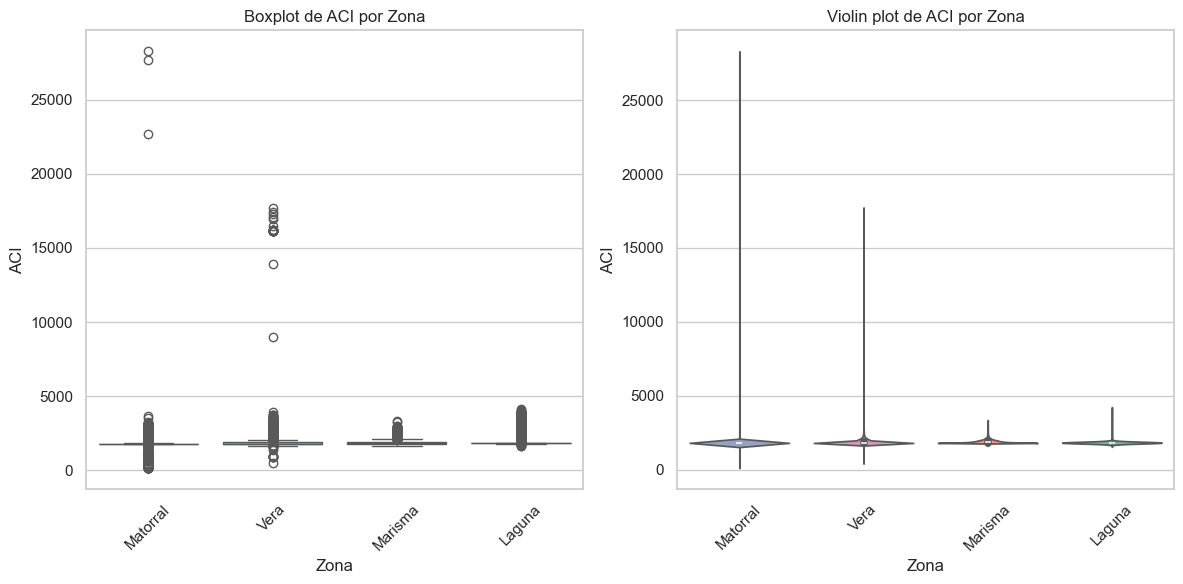

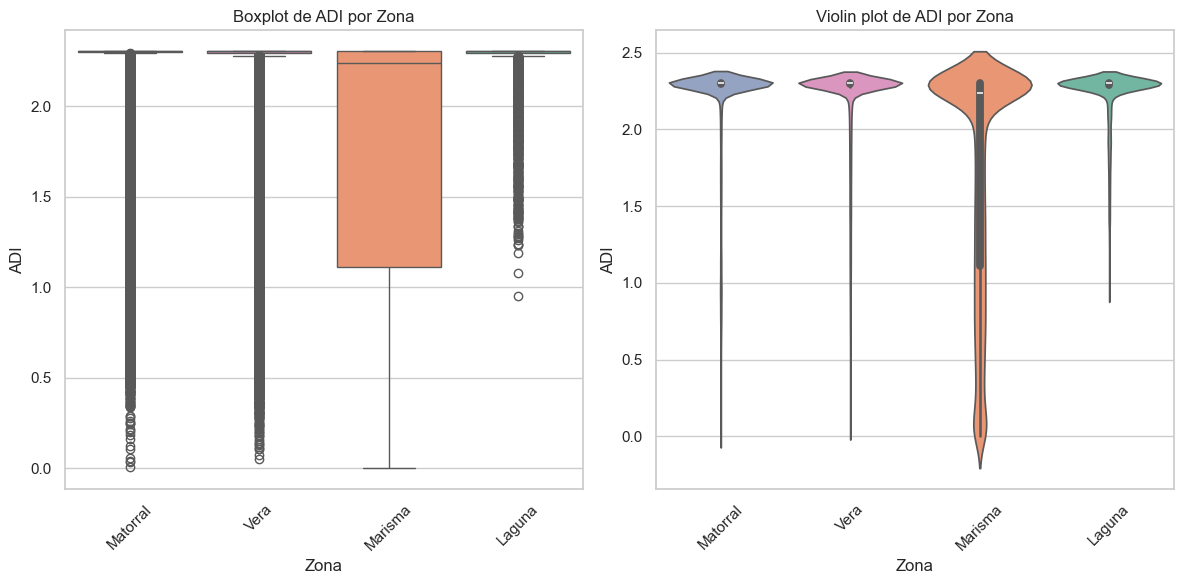

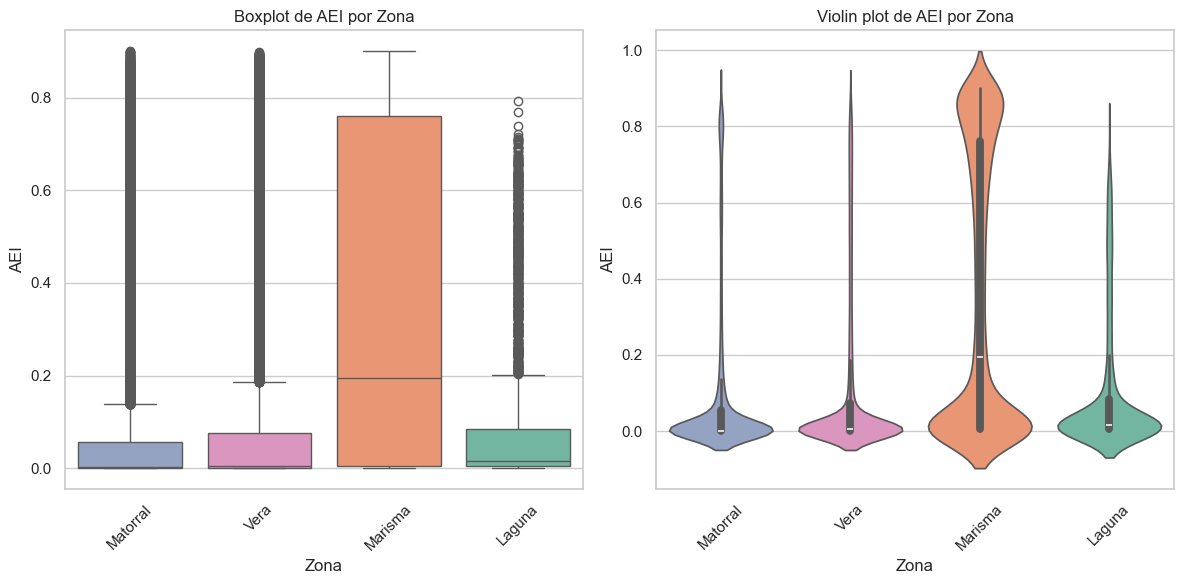

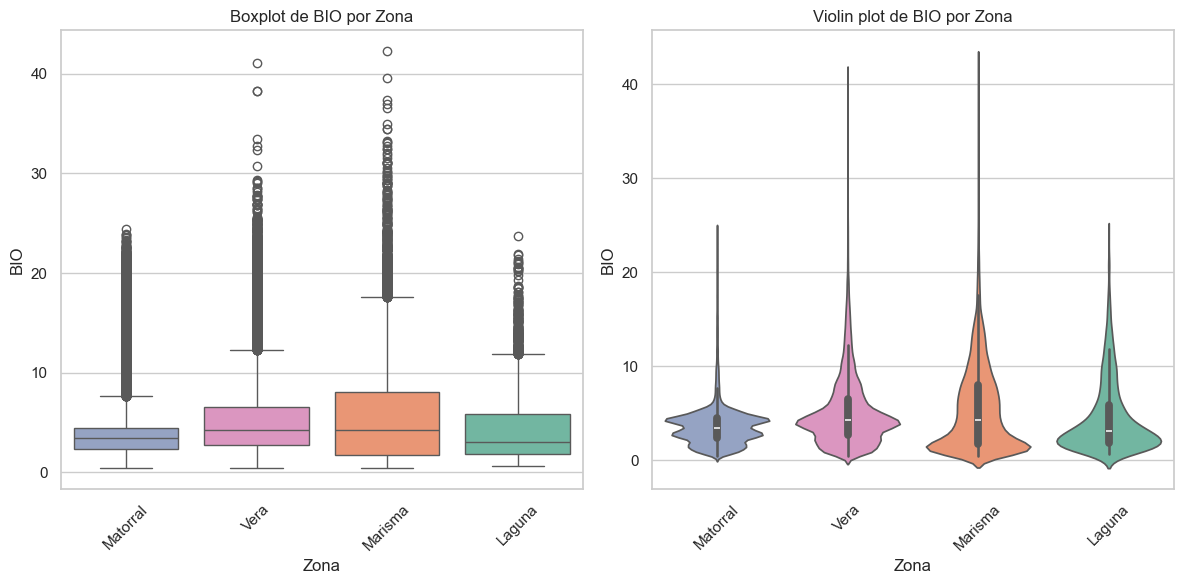

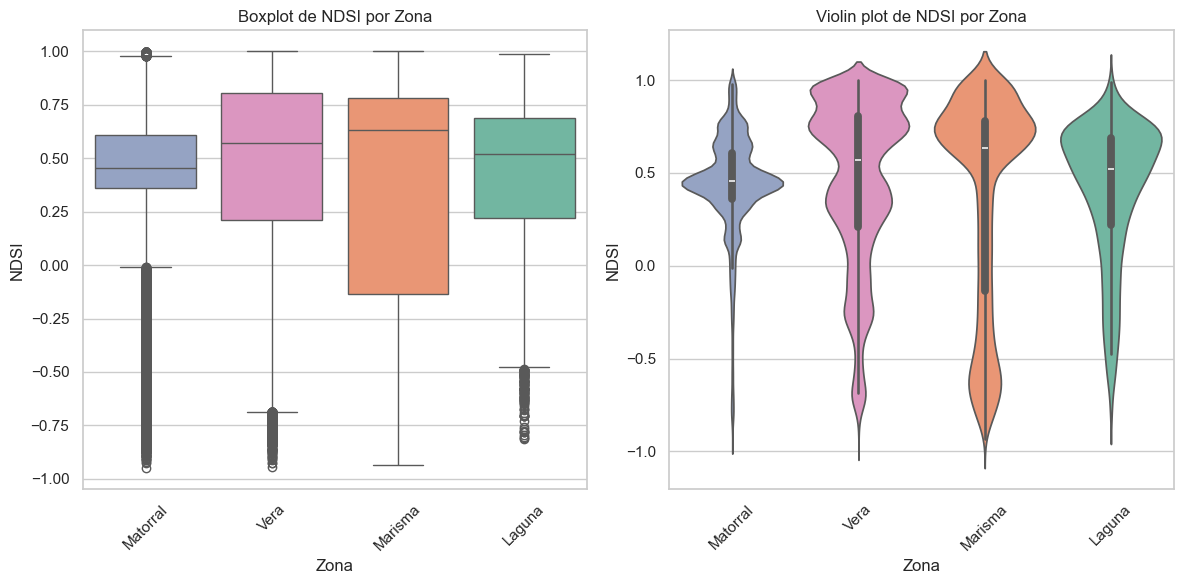

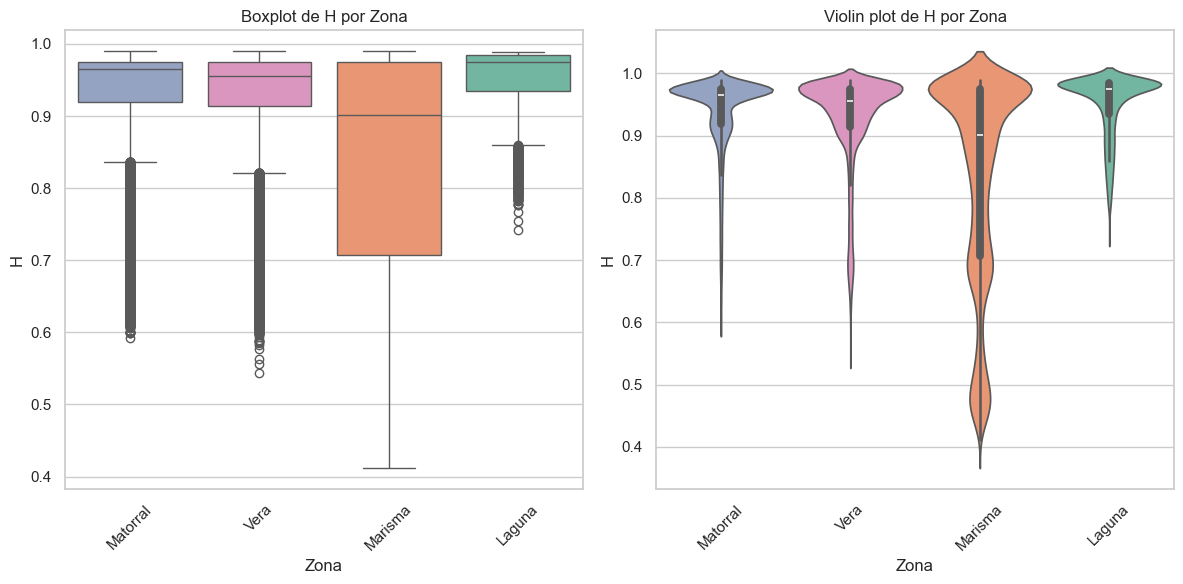

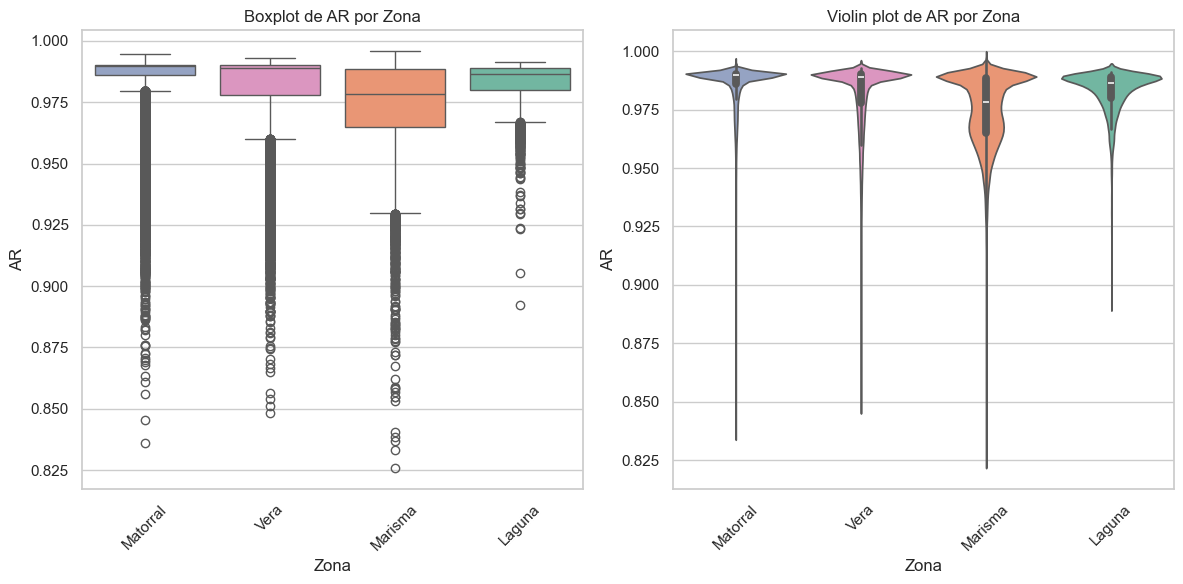

In [7]:
# Ajustar el estilo de los gráficos
sns.set(style="whitegrid")

sorted_zones = sorted(df_indices["zone"].unique())
palette = sns.color_palette("Set2", n_colors=len(sorted_zones))
zone_colors = dict(zip(sorted_zones, palette))

# Iterar sobre cada índice y crear gráficos
for idx in indices:
    plt.figure(figsize=(12, 6))

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df_indices, x="zone", y=idx, hue="zone", palette=zone_colors, dodge=False)
    plt.title(f"Boxplot de {idx} por Zona")
    plt.xlabel("Zona")
    plt.ylabel(idx)
    plt.xticks(rotation=45)
    plt.legend([],[], frameon=False)  # Desactivar la leyenda

    # Violin plot
    plt.subplot(1, 2, 2)
    sns.violinplot(data=df_indices, x="zone", y=idx, hue="zone", inner="box", palette=zone_colors, dodge=False)
    plt.title(f"Violin plot de {idx} por Zona")
    plt.xlabel("Zona")
    plt.ylabel(idx)
    plt.xticks(rotation=45)
    plt.legend([],[], frameon=False)  # Desactivar la leyenda

    plt.tight_layout()
    plt.show()

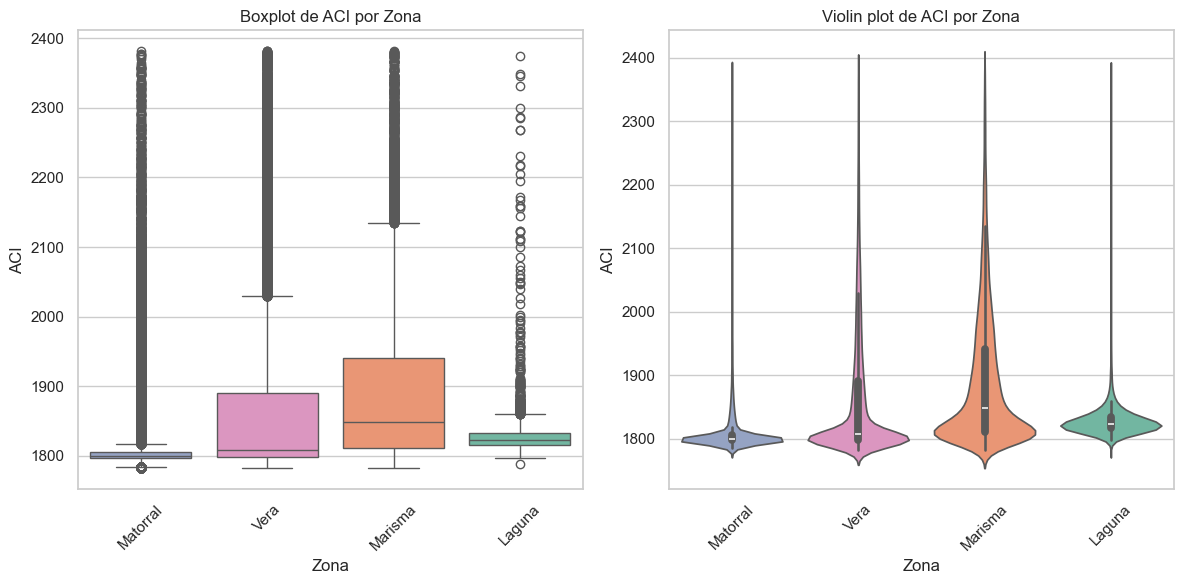

In [8]:
# Ajustar el estilo de los gráficos
sns.set(style="whitegrid")

sorted_zones = sorted(df_indices["zone"].unique())
palette = sns.color_palette("Set2", n_colors=len(sorted_zones))
zone_colors = dict(zip(sorted_zones, palette))

# Calcular los percentiles para ACI y filtrar el dataframe
lower_bound = df_indices["ACI"].quantile(0.01)
upper_bound = df_indices["ACI"].quantile(0.99)
df_aci = df_indices[(df_indices["ACI"] >= lower_bound) & (df_indices["ACI"] <= upper_bound)]

plt.figure(figsize=(12, 6))

# Boxplot para ACI
plt.subplot(1, 2, 1)
sns.boxplot(data=df_aci, x="zone", y="ACI", hue="zone", palette=zone_colors, dodge=False)
plt.title("Boxplot de ACI por Zona")
plt.xlabel("Zona")
plt.ylabel("ACI")
plt.xticks(rotation=45)
plt.legend([], [], frameon=False)

# Violin plot para ACI
plt.subplot(1, 2, 2)
sns.violinplot(data=df_aci, x="zone", y="ACI", hue="zone", inner="box", palette=zone_colors, dodge=False)
plt.title("Violin plot de ACI por Zona")
plt.xlabel("Zona")
plt.ylabel("ACI")
plt.xticks(rotation=45)
plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()